<a href="https://colab.research.google.com/github/lowbee2019/Algorithm/blob/master/MyModel_CNN-V6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 实验环境准备

In [2]:
!pip install emnist

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets,layers,models
import collections
import copy
import random
import emnist
import datetime
import os
import matplotlib.pyplot as plt

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Server Initialization

In [5]:
class ParamServer(object):
  def __init__(self,init_model_path):
    self.init_model_path = init_model_path
    self.round = 0
    self.optimizer = 'adam'
    self.loss = "sparse_categorical_crossentropy"
    self.metrics =['accuracy']
    self.loss_acc = []

  def PreTrain(self,model,data,labels,batch_size=32,epochs=5):
    model.compile(optimizer=self.optimizer,
                  loss=self.loss,
                  metrics=self.metrics)
    _metrics = model.fit(data,labels,batch_size,epochs)
    return model
  
  def PreEval(self,model,validation_data):
    model.compile(optimizer=self.optimizer,
                  loss=self.loss,
                  metrics=self.metrics)
    self.loss_acc.append(model.evaluate(x=validation_data[0],y=validation_data[1]))


## Emnist数据集的预处理

In [6]:
LetterDataSet = emnist.extract_training_samples('letters')
DigitDataSet = emnist.extract_training_samples('digits')

LetterDataSet = (np.expand_dims(LetterDataSet[0]/255.0,axis=3),np.expand_dims(LetterDataSet[1]*0+10,axis=1)) 
DigitDataSet = (np.expand_dims(DigitDataSet[0]/255.0,axis=3),np.expand_dims(DigitDataSet[1],axis=1))

In [7]:
LetterDataSet[0].shape,DigitDataSet[0].shape

((124800, 28, 28, 1), (240000, 28, 28, 1))

In [51]:
ShareData = DigitDataSet[0][0:200]
ShareLabel = DigitDataSet[1][0:200]
validation_data=(ShareData,ShareLabel)
validation_sever = (DigitDataSet[0][200:400],DigitDataSet[1][200:400])

## 模型的定义

In [9]:
class FLModel(tf.keras.Model):
  def __init__(self,row,col,num_classes=62,*args,**kwargs):
    super(FLModel,self).__init__(*args,**kwargs)
    self.row = row
    self.col = col
    self.num_classes = num_classes
    # self.flatten = tf.keras.layers.Flatten(input_shape=(row,col))
    # self.dense_1 = tf.keras.layers.Dense(128,activation='relu',name="dense_1")
    # self.dense_2 = tf.keras.layers.Dense(num_classes,activation='softmax',name="dense_2")
    # self.drop = tf.keras.layers.Dropout(0.2)
    
    self.model = models.Sequential()
    # 第1层卷积，卷积核大小为3*3，32个，28*28为待训练图片的大小
    self.model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(self.row, self.col, 1)))
    self.model.add(layers.MaxPooling2D((2, 2)))
    # 第2层卷积，卷积核大小为3*3，64个
    self.model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    self.model.add(layers.MaxPooling2D((2, 2)))
    # 第3层卷积，卷积核大小为3*3，64个
    self.model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    self.model.add(layers.Flatten())
    self.model.add(layers.Dense(64, activation='relu'))
    self.model.add(layers.Dense(num_classes, activation='softmax'))

  def call(self,inputs):
    return self.model(inputs)

  def copy(self):
    NewModel = FLModel(self.row,self.col,self.num_classes)
    _ = NewModel(tf.convert_to_tensor(np.zeros([1,self.row,self.col,1])))
    ##Layers
    NewVars = NewModel.trainable_variables #此处为空列表，因为没有训练,这个地方参数传递是不是有问题
    OldVars = self.trainable_variables
    for n,o in zip(NewVars,OldVars):
      n.assign(o.numpy())
    return NewModel


#Client Initialization

In [10]:
class Client(object):
  def __init__(self,id,model=None,Train_dataset=None,Test_dataset=None):
    self.id = id
    self.model = model
    self.Train_dataset = Train_dataset
    self.Test_dataset = Test_dataset
    # from ParamServer
    self.ParamModel = None
    self.num_epochs = 5
    self.batch_size = 32
    self.shuffle_buffer = 100
    self.prefetch_buffer = 10


  def ReceiveModel(self,ParamModel,num_epochs=1,batch_size=32,shuffle_buffer=100,prefetch_buffer=10):
    self.ParamModel = ParamModel
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.shuffle_buffer = shuffle_buffer
    self.prefetch_buffer = prefetch_buffer
  

  def NodeTrain(self):
    model = self.ParamModel
    x,y = self.Train_dataset
    model.compile(
        # optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),##'adam',
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    _metrics = model.fit(x,y,batch_size=self.batch_size,epochs=self.num_epochs)
    self.model = model

  def NodeEval(self):
    x,y = self.Test_dataset
    return self.model.evaluate(x,y)


In [11]:
def create_data_for_clients(SampleNum,LetterDataSet,DigitDataSet,DigitPercentage=0.7):
  DigitNum = int(SampleNum*DigitPercentage)
  LetterNum = SampleNum - DigitNum
  x_sequence = []
  y_sequence = []
  if DigitNum > 0:
    for i in range(DigitNum):
      index = random.randint(0,len(DigitDataSet[0])-1)
      x_sequence.append(DigitDataSet[0][index])
      y_sequence.append(DigitDataSet[1][index])
  if LetterNum > 0:
    for j in range(LetterNum):
      index = random.randint(0,len(LetterDataSet[0])-1)
      x_sequence.append(LetterDataSet[0][index])
      y_sequence.append(LetterDataSet[1][index])
  # print(x_sequence[1].shape,y_sequence[1].shape)
  x = np.array(x_sequence,dtype=np.float64)
  y = np.array(y_sequence,dtype=np.int8)
  #shuffle
  state = np.random.get_state()
  np.random.shuffle(x)
  np.random.set_state(state)
  np.random.shuffle(y)
  
  return (x,y)

#阶段一：为Client分配数据（预处理工作）

In [61]:
NUM_CLIENTS = 12
NUM_TRAIN_SAMPLE_CLIENT = 256
NUM_TEST_SAMPLE_CLIENT = 256
CLASS_NUM = 11
NUM_EPOCHS = 20

In [62]:
clients=[]
for i in range(NUM_CLIENTS):
  clients.append(Client(i,
                        Train_dataset=create_data_for_clients(SampleNum=256,
                                                              LetterDataSet=LetterDataSet,
                                                              DigitDataSet=DigitDataSet,
                                                              DigitPercentage=random.random()),
                        Test_dataset=validation_data
                        )
  )

Show DataSet

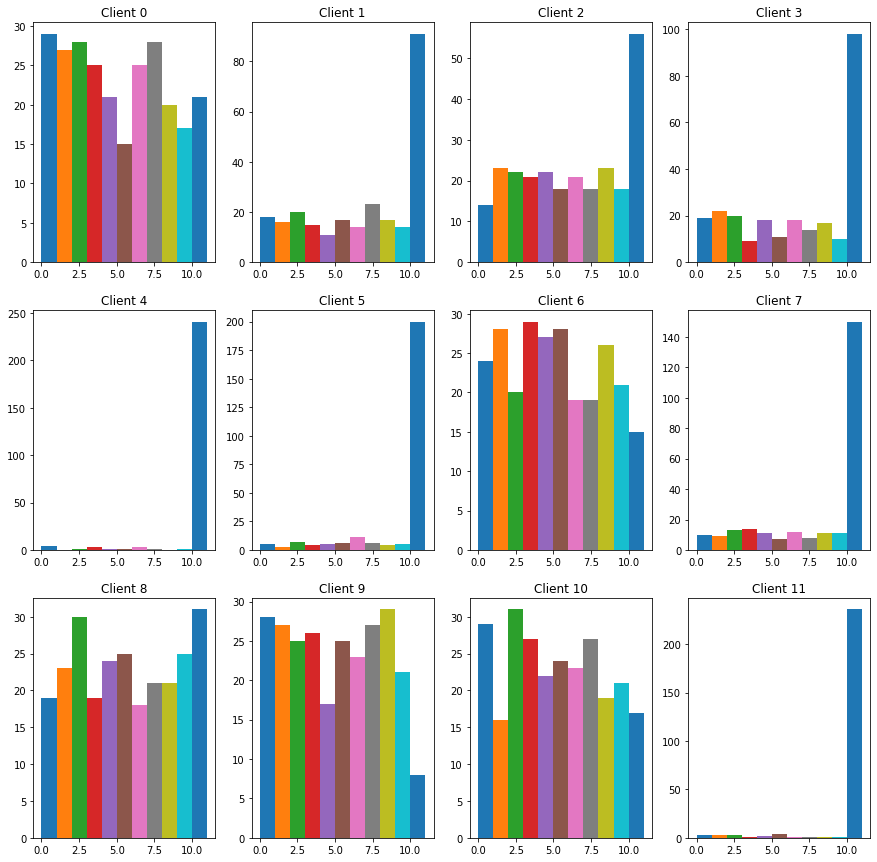

In [63]:

f = plt.figure(figsize=(15,15))
for i in range(NUM_CLIENTS):
  client_dataset = clients[i].Train_dataset
  plot_data = collections.defaultdict(list)
  for [label] in client_dataset[1].tolist():
    plot_data[label].append(label)
  plt.subplot(3,4,i+1)
  plt.title('Client {}'.format(i))
  for j in range(CLASS_NUM):
    plt.hist(
        plot_data[j],
        density = False,
        bins = [x for x in range(len(plot_data)+1)]
    )

显示一下数字与字母的对比


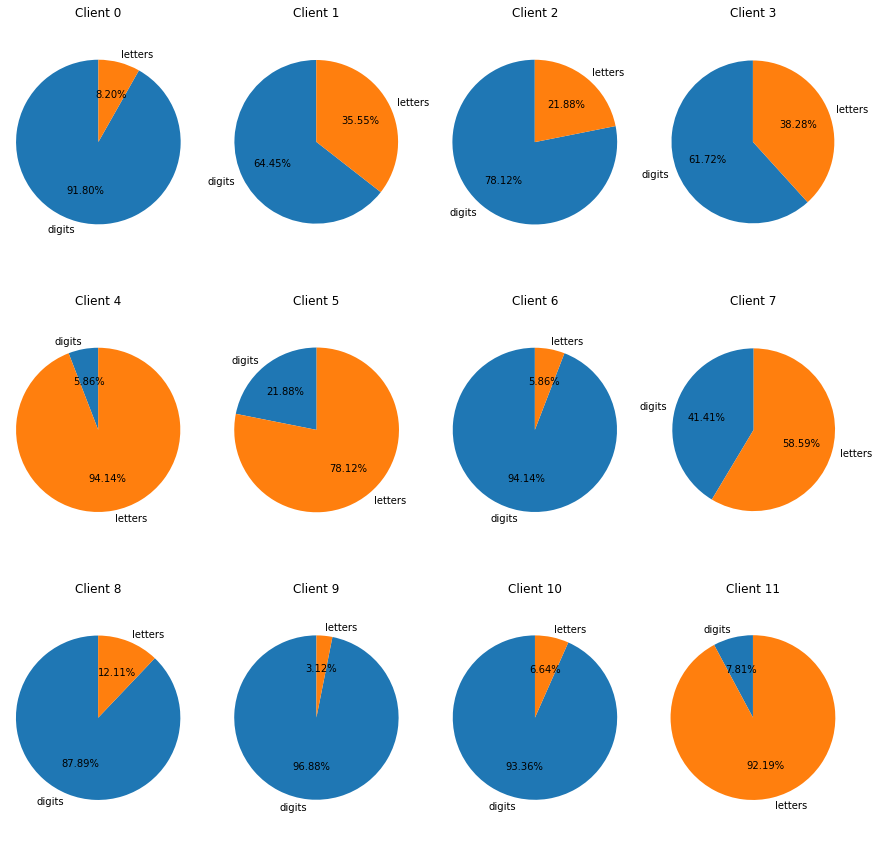

In [64]:
f = plt.figure(figsize=(15,15))
for i in range(NUM_CLIENTS):
  client_dataset = clients[i].Train_dataset
  plot_data = {0:0,1:0}
  plot_labels = ['digits','letters']
  for label in client_dataset[1]:
    label = 0 if label < 10 else 1
    plot_data[label]+=1
  # print(plot_data)
  data_labels = list(sorted(plot_data.keys()))
  # print(data_labels)
  data_nums = [plot_data[i] for i in data_labels]
  colors = ['red','blue']
  plt.subplot(3,4,i+1)
  patches,text1,text2 = plt.pie(data_nums,
                              labels=plot_labels,
                              autopct='%3.2f%%',
                              shadow=False,
                              startangle=90,
                              pctdistance=0.6)
  plt.axis('equal')
  plt.title('Client {}'.format(i))
plt.show()


#阶段二：中央服务器下发模型

Distance Between two models

In [16]:
def Distance(HookModel,TestModel):
  len_it = len(HookModel.trainable_variables)
  Hook_weights=[]
  Test_weights=[]
  for index in range(len_it):
    Hook_weights.append(HookModel.trainable_variables[index].numpy().reshape(-1,))
    Test_weights.append(TestModel.trainable_variables[index].numpy().reshape(-1,))
  target = []
  dis_norm2=[]
  for i in range(len_it):
    target.append(Hook_weights[i]-Test_weights[i])
    dis_norm2.append(np.linalg.norm(target[i],2))
  weight_weights = np.ones([len_it,1])
  #调整权重
  # weight_weights[0]=0
  # weight_weights[1]=0
  dis = np.dot(dis_norm2,weight_weights)
  return dis

In [17]:
def GetDistDict(Clients,Clients_Num,TargetModel):
  """
  return {'client id':Distance(TargetModel,client_id.model)}
  """
  DistDict = collections.OrderedDict()
  for i in range(Clients_Num):
    DistDict[i] = Distance(TargetModel,Clients[i].model)
  return DistDict

In [18]:
def ParticipatedNode(AccuracyList,AccThreshold=0.05):
  tmp = [i for i in range(len(AccuracyList)) if AccuracyList[i]>AccThreshold]

  if len(tmp):
    return tmp
  else:
    return [i for i in range(len(AccuracyList))]

In [16]:
def BetterNode(clients,model,Total_NUM,FedAvg_NUM):
  NodeDict=collections.OrderedDict()
  for i in range(Total_NUM):
    NodeDict[i] = Distance(model,clients[i].model)
  Dlst = sorted(NodeDict.items(),key=lambda x:x[1])
  NodeList = []
  for i in range(FedAvg_NUM):
    NodeList.append(Dlst[i][0])
  return (NodeList,NodeDict)

模型初始化

In [65]:
InitModel = FLModel(row=28,col=28,num_classes=CLASS_NUM)
S = ParamServer("")
S.PreEval(InitModel,validation_data)
SendModel = InitModel

7/7 [==============================] - 0s 3ms/step - loss: 2.3994 - accuracy: 0.0960


In [ ]:
#InitModel.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

使用随机初始化的模型进行预测，不预测也可以！

In [ ]:
SendModel = S.PreTrain(InitModel,ShareData,ShareLabel,epochs=1)
S.PreEval(SendModel,validation_data)

7/7 [==============================] - 0s 3ms/step - loss: 2.1860 - accuracy: 0.1877


# 阶段三：Clients 训练节点数据并聚合


In [34]:
def FedAvgwithAcc(NUM_CLIENTS,model,AccuracyList):
  iterModel = model.copy()
  len_it = len(iterModel.trainable_variables)
  all_weights = []
  # FedNodeList,NodeDict=BetterNode(clients,iterModel,NUM_CLIENTS,FedAvg_NUM=8)
  NodeDict = GetDistDict(Clients=clients,Clients_Num=NUM_CLIENTS,TargetModel=iterModel)
  FedNodeList = ParticipatedNode(AccuracyList=AccuracyList,AccThreshold=-1) # "-1" means that each one participate FedAvg.

  # print("FedAvg Node is",FedNodeList)
  print("FedNodeList is ",FedNodeList)
  # mult = [AccuracyList[i]/np.exp(NodeDict[i]) for i in range(NUM_CLIENTS)] # no threshold
  mult = [AccuracyList[i]/np.exp(NodeDict[i]) for i in FedNodeList] 
  # print("The Distance are ...",NodeDict)
  # print("The AD are ...",mult)
  exp_sum = np.sum(mult)
  # Weights = mult/exp_sum
  Weights = {k:v for (k,v) in zip(FedNodeList,mult/exp_sum)}
  print("Weights are...",Weights)
  ###Softmax

  for weights_index in range(len_it):
    tmp =np.zeros(iterModel.trainable_variables[weights_index].numpy().shape,dtype='float64')

    for node in FedNodeList:
    # for node in range(NUM_CLIENTS):
      tmp += clients[node].model.trainable_variables[weights_index].numpy()*Weights[node]
    all_weights.append(tmp)
  # print(all_weights)
  iterModel_vars = iterModel.trainable_variables
  for iter_v,n in zip(iterModel_vars,all_weights):
    iter_v.assign(n)
  return (iterModel,FedNodeList,Weights)

In [66]:
NodeList=[]
ACC_Client_Test=[]
WeightsEachEpoche = []
for e in range(NUM_EPOCHS):
  Acc_tmp=[]
  Weight_tmp=[]
  print("EPOCHS {} is starting...".format(e))
  for i in range(NUM_CLIENTS):
    clients[i].ReceiveModel(SendModel.copy())
    clients[i].NodeTrain()
    Acc_tmp.append(clients[i].NodeEval()[1])

  FedModel,li,Weight_tmp = FedAvgwithAcc(NUM_CLIENTS,SendModel,AccuracyList=Acc_tmp)
  #---Recording---
  NodeList.append(li)
  WeightsEachEpoche.append(Weight_tmp)
  ACC_Client_Test.append(Acc_tmp)
  print("The Acc on each client...",Acc_tmp)
  #---Testing---
  S.PreEval(FedModel,validation_sever)
  SendModel = FedModel.copy()

EPOCHS 0 is starting...
7/7 [==============================] - 0s 3ms/step - loss: 11.1062 - accuracy: 0.0000e+00
FedNodeList is  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Weights are... {0: array([0.19414432]), 1: array([0.]), 2: array([0.]), 3: array([0.]), 4: array([0.]), 5: array([0.]), 6: array([0.2794785]), 7: array([0.]), 8: array([0.21407114]), 9: array([0.17310568]), 10: array([0.13920036]), 11: array([0.])}
The Acc on each client... [0.3449999988079071, 0.0, 0.0, 0.0, 0.0, 0.0, 0.48500001430511475, 0.0, 0.35499998927116394, 0.32499998807907104, 0.2549999952316284, 0.0]
7/7 [==============================] - 0s 3ms/step - loss: 2.2287 - accuracy: 0.4615
EPOCHS 1 is starting...
7/7 [==============================] - 0s 2ms/step - loss: 8.2895 - accuracy: 0.0000e+00
FedNodeList is  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Weights are... {0: array([0.22298951]), 1: array([0.]), 2: array([0.05209871]), 3: array([0.]), 4: array([0.]), 5: array([0.]), 6: array([0.17824147]), 7: array([0.

In [60]:
WeightsEachEpoche

[{0: array([0.]),
  1: array([0.]),
  2: array([0.]),
  3: array([0.]),
  4: array([0.42381191]),
  5: array([0.03464526]),
  6: array([0.]),
  7: array([0.]),
  8: array([0.54154283]),
  9: array([0.]),
  10: array([0.]),
  11: array([0.])},
 {0: array([0.]),
  1: array([0.00532744]),
  2: array([0.]),
  3: array([0.]),
  4: array([0.30509825]),
  5: array([0.23902556]),
  6: array([0.]),
  7: array([0.07246714]),
  8: array([0.20034362]),
  9: array([0.]),
  10: array([0.17773798]),
  11: array([0.])},
 {0: array([0.]),
  1: array([0.16892834]),
  2: array([0.]),
  3: array([0.0090521]),
  4: array([0.17818937]),
  5: array([0.18789113]),
  6: array([0.]),
  7: array([0.15475395]),
  8: array([0.14434162]),
  9: array([0.]),
  10: array([0.15684349]),
  11: array([0.])},
 {0: array([0.]),
  1: array([0.1156111]),
  2: array([0.]),
  3: array([0.05923383]),
  4: array([0.14661067]),
  5: array([0.17033132]),
  6: array([0.]),
  7: array([0.1780402]),
  8: array([0.19844349]),
  9: arr

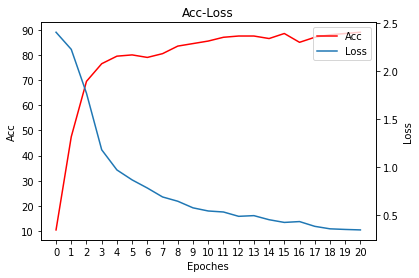

In [67]:
#deal the data
S_acc =[S.loss_acc[i][1]*100 for i in range(len(S.loss_acc))]
S_loss =[S.loss_acc[i][0] for i in range(len(S.loss_acc))]

#prepare show image
x = np.arange(len(S.loss_acc)).astype(dtype=np.str)
fig = plt.figure()
ax1 = fig.add_subplot(111)
acc = ax1.plot(x,S_acc,'r',label='Acc')
ax1.set_ylabel('Acc')
ax1.set_xlabel("Epoches")
ax1.set_title('Acc-Loss')

ax2 = ax1.twinx()
loss = ax2.plot(x,S_loss,label='Loss')
ax2.set_ylabel('Loss')


lns = acc+loss
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs)
plt.show()

In [23]:
NodeList

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]

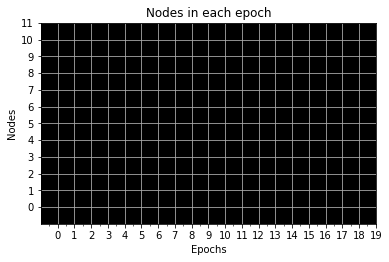

In [55]:
#deal the data
img = np.ones(shape=(NUM_CLIENTS,NUM_EPOCHS),dtype=int)
for i in range(len(NodeList)):
  for j in NodeList[i]:
    img[j][i]=0
#prepare show image
len_n = len(S.loss_acc)
ax = plt.gca()
ax.set_ylim(-0.5,NUM_CLIENTS-0.5)
ax.set_xlim(-0.5,9.5)
miloc = plt.MultipleLocator(1)
ax.xaxis.set_minor_locator(miloc)
plt.grid()
plt.title("Nodes in each epoch")
plt.imshow(img*255,cmap='gray')
plt.axis('on')
plt.xlabel('Epochs')
plt.ylabel('Nodes')
y = np.arange(0.5,NUM_CLIENTS+0.5,1)
x = np.arange(0.5,NUM_EPOCHS+0.5,1)
plt.xticks()
plt.yticks(y,(int(i-0.5) for i in y))
plt.xticks(x,(int(i-0.5) for i in x))
plt.show()

# 阶段四：设置对照组，即普通的FedAvg

In [25]:
def FedAvg_Baseline(NUM_CLIENTS,model):
  iterModel = model.copy()
  len_it = len(iterModel.trainable_variables)
  all_weights = []
  for weights_index in range(len_it):
    tmp =np.zeros(iterModel.trainable_variables[weights_index].numpy().shape,dtype='float64')
    for node in range(NUM_CLIENTS):
      tmp += clients[node].model.trainable_variables[weights_index].numpy()
    all_weights.append(tmp/NUM_CLIENTS)
  # print(all_weights)
  iterModel_vars = iterModel.trainable_variables
  for iter_v,n in zip(iterModel_vars,all_weights):
    iter_v.assign(n)
  return iterModel

In [68]:
InitModel = FLModel(row=28,col=28,num_classes=CLASS_NUM)
S2 = ParamServer("")
S2.PreEval(InitModel,validation_data)
SendModel = InitModel

7/7 [==============================] - 0s 2ms/step - loss: 2.3944 - accuracy: 0.0746


In [ ]:
SendModel = S2.PreTrain(InitModel,DigitDataSet[0][0:200],DigitDataSet[1][0:200],epochs=1)
S2.PreEval(SendModel,validation_data)

7/7 [==============================] - 0s 3ms/step - loss: 2.1797 - accuracy: 0.2646


In [69]:
for e in range(NUM_EPOCHS):
  print("EPOCHS {} is starting...".format(e))
  for i in range(NUM_CLIENTS):
    clients[i].ReceiveModel(SendModel.copy())
    clients[i].NodeTrain()
    # clients[i].NodeEval()
    # DIS.append(Distance(SendModel,clients[i].model))
  FedModel = FedAvg_Baseline(NUM_CLIENTS,SendModel)
  S2.PreEval(FedModel,validation_sever)
  SendModel = FedModel.copy()

EPOCHS 0 is starting...
7/7 [==============================] - 0s 2ms/step - loss: 2.5495 - accuracy: 0.0000e+00
EPOCHS 1 is starting...
7/7 [==============================] - 0s 3ms/step - loss: 2.4055 - accuracy: 0.0000e+00
EPOCHS 2 is starting...
7/7 [==============================] - 0s 3ms/step - loss: 2.2666 - accuracy: 0.0303
EPOCHS 3 is starting...
7/7 [==============================] - 0s 3ms/step - loss: 1.8737 - accuracy: 0.2283
EPOCHS 4 is starting...
7/7 [==============================] - 0s 3ms/step - loss: 1.5917 - accuracy: 0.3733
EPOCHS 5 is starting...
7/7 [==============================] - 0s 3ms/step - loss: 1.2963 - accuracy: 0.4907
EPOCHS 6 is starting...
7/7 [==============================] - 0s 3ms/step - loss: 1.0238 - accuracy: 0.7050
EPOCHS 7 is starting...
7/7 [==============================] - 0s 3ms/step - loss: 1.0164 - accuracy: 0.6524
EPOCHS 8 is starting...
7/7 [==============================] - 0s 3ms/step - loss: 0.7567 - accuracy: 0.8009
EPOCHS 9 is

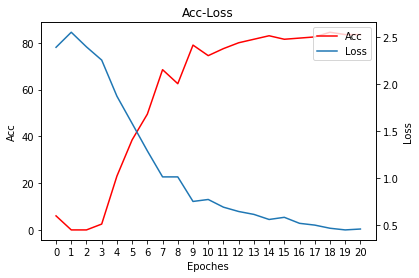

In [70]:
S_acc2 =[S2.loss_acc[i][1]*100 for i in range(len(S2.loss_acc))]
S_loss2 =[S2.loss_acc[i][0] for i in range(len(S2.loss_acc))]

x = np.arange(len(S2.loss_acc)).astype(dtype=np.str)
fig = plt.figure()
ax1 = fig.add_subplot(111)
acc = ax1.plot(x,S_acc2,'r',label='Acc')
ax1.set_ylabel('Acc')
ax1.set_title('Acc-Loss')
ax1.set_xlabel("Epoches")

ax2 = ax1.twinx()
loss = ax2.plot(x,S_loss2,label='Loss')
ax2.set_ylabel('Loss')

lns = acc+loss
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs)
plt.show()

# 实验结果对比

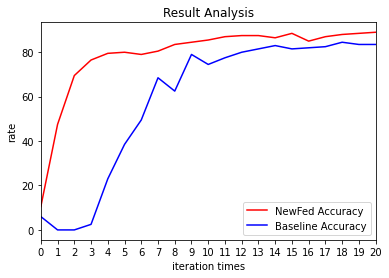

In [71]:
iters = np.arange(len(S2.loss_acc)).astype(dtype=np.str)
fig = plt.figure()
plt.title('Result Analysis')
plt.plot(iters,S_acc,color='red',label='NewFed Accuracy')
plt.plot(iters,S_acc2,color='blue',label='Baseline Accuracy')
plt.legend()
plt.xlabel('iteration times')
plt.ylabel('rate')
plt.xlim(0,20)
plt.show()